# ECG Beat Annotation UI

Segment-based annotation: scroll through 20s segments, click on any beat to inspect and relabel it.
Annotations are saved to `annotations.csv` for future ML training.

**Workflow:** Scan the top trace visually. Click any beat that looks misclassified. The zoomed view appears below with label buttons. Most beats need no action.

In [5]:
%matplotlib widget

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import sys
sys.path.insert(0, '.')
from ecg_library.filters import filter_signal
from ecg_library.utils import load_ecg_data, parse_folder
from ecg_library.annotations import load_annotations, save_annotation, get_annotation_status

# Constants
FS = 125
SEGMENT_SEC = 20
SEGMENT_SAMPLES = SEGMENT_SEC * FS
ZOOM_WINDOW = int(0.75 * FS)  # samples each side of R-peak for zoomed view
ANNOTATIONS_PATH = 'annotations.csv'
DATA_DIR = 'Data'

# Color map: algo labels -> marker colors
ALGO_COLORS = {
    'normal': '#2ecc71',
    'PVC': '#e74c3c',
    'VT': '#e67e22',
    'undetected': '#ff00ff',
}
LABEL_COLORS = {
    'Normal': '#2ecc71',
    'PVC': '#e74c3c',
    'VT': '#e67e22',
    'PAC': '#3498db',
    'AV': '#8e44ad',
    'Artifact': '#95a5a6',
    'Other': '#7f8c8d',
}
VALID_LABELS = list(LABEL_COLORS.keys())

print('Imports OK')

Imports OK


In [6]:
# --- Session loading ---

def find_sessions(data_dir=DATA_DIR):
    """Find all Data/ subfolders that have a rich_processed_beats.csv."""
    sessions = []
    for name in sorted(os.listdir(data_dir)):
        folder = os.path.join(data_dir, name)
        if not os.path.isdir(folder):
            continue
        csvs = glob.glob(os.path.join(folder, '*_rich_processed_beats.csv'))
        if csvs:
            sessions.append(name)
    return sessions


def load_session(session_name, annotations_df):
    """Load a session's signal and beat list, merging existing annotations."""
    folder = os.path.join(DATA_DIR, session_name)
    csv_files = glob.glob(os.path.join(folder, '*_rich_processed_beats.csv'))
    rich_df = pd.read_csv(csv_files[0])

    combined_ecg, combined_time, fs, file_paths = load_ecg_data(folder)
    filtered_ecg = filter_signal(combined_ecg, fs)
    _, start_time = parse_folder(session_name)

    beats = []
    session_annots = annotations_df[annotations_df['session'] == session_name]
    annotated_r_indices = set(session_annots['r_index'].values)

    for _, row in rich_df.iterrows():
        r_idx = int(row['r_index'])
        algo_label = row['beat_type']
        human_label = None
        if r_idx in annotated_r_indices:
            match = session_annots[session_annots['r_index'] == r_idx]
            if len(match) > 0:
                human_label = match.iloc[0]['human_label']

        beats.append({
            'r_index': r_idx,
            'algo_label': algo_label,
            'human_label': human_label,
            'abs_r_time': row.get('abs_r_time', ''),
            'r_amplitude': row.get('r_amplitude', ''),
            'rr_interval': row.get('rr_interval', ''),
            'qrs_duration': row.get('qrs_duration', ''),
            'qt_interval': row.get('qt_interval', ''),
            'p_index': row.get('p_index', None),
            'q_index': row.get('q_index', None),
            's_index': row.get('s_index', None),
            't_index': row.get('t_index', None),
        })

    # Also load any manually-added beats from annotations that aren't in the rich CSV
    rich_r_indices = set(int(row['r_index']) for _, row in rich_df.iterrows())
    for _, arow in session_annots.iterrows():
        r_idx = int(arow['r_index'])
        if r_idx not in rich_r_indices:
            beats.append({
                'r_index': r_idx,
                'algo_label': 'undetected',
                'human_label': arow['human_label'],
                'abs_r_time': arow.get('abs_r_time', ''),
                'r_amplitude': arow.get('r_amplitude', ''),
                'rr_interval': arow.get('rr_interval', ''),
                'qrs_duration': arow.get('qrs_duration', ''),
                'qt_interval': '',
                'p_index': None, 'q_index': None, 's_index': None, 't_index': None,
            })

    # Keep beats sorted by r_index (time order) for segment view
    beats.sort(key=lambda b: b['r_index'])
    return filtered_ecg, combined_time, beats, start_time


sessions = find_sessions()
print(f'Found {len(sessions)} sessions with processed beats')

Found 246 sessions with processed beats


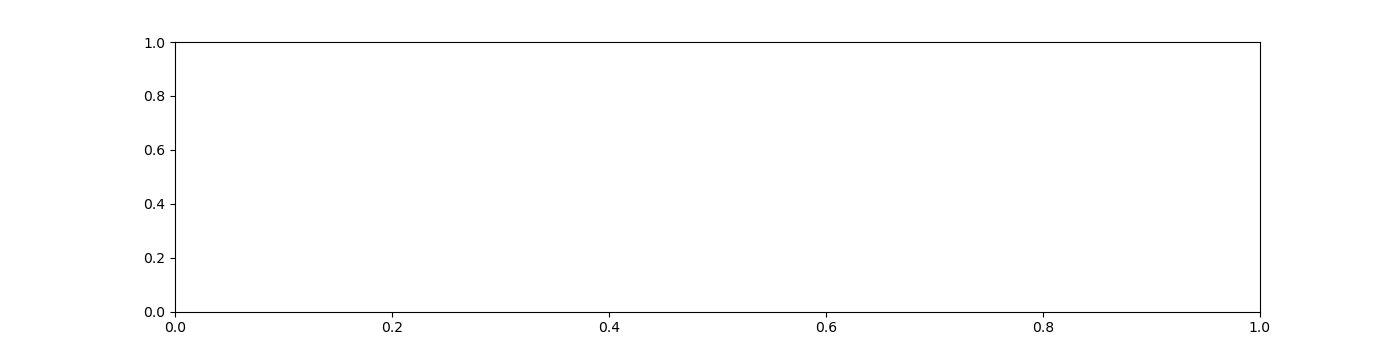

In [8]:
# --- Segment-based Annotation UI ---

from datetime import timedelta
from scipy.signal import find_peaks

state = {
    'session': None,
    'filtered_ecg': None,
    'combined_time': None,
    'start_time': None,
    'beats': [],
    'seg_idx': 0,          # current segment index
    'n_segments': 0,
    'selected_beat': None,  # index into beats list
}

# --- Widgets ---
session_dropdown = widgets.Dropdown(
    options=['-- Select --'] + sessions,
    value='-- Select --',
    description='Session:',
    layout=widgets.Layout(width='80%'),
    style={'description_width': '65px'},
)
progress_label = widgets.HTML(value='<i>Select a session to begin.</i>')
info_label = widgets.HTML(value='')

btn_prev_seg = widgets.Button(description='\u2190 Prev 20s', layout=widgets.Layout(width='110px'))
btn_next_seg = widgets.Button(description='Next 20s \u2192', layout=widgets.Layout(width='110px'))
btn_deselect = widgets.Button(description='Deselect', layout=widgets.Layout(width='90px'),
                              style={'button_color': '#ecf0f1'})

seg_input = widgets.BoundedIntText(
    value=1, min=1, max=1,
    description='Seg #:',
    layout=widgets.Layout(width='130px'),
    style={'description_width': '40px'},
)

label_buttons = {}
for lbl in VALID_LABELS:
    label_buttons[lbl] = widgets.Button(
        description=lbl,
        layout=widgets.Layout(width='90px', height='36px'),
        style={'button_color': LABEL_COLORS[lbl]},
    )

# Separator between nav and label buttons
separator = widgets.HTML(value='<span style="color:#bbb; font-size:18px; padding:0 6px;">\u2502</span>')

label_row = widgets.HBox(list(label_buttons.values()))
action_bar = widgets.HBox(
    [btn_prev_seg, seg_input, btn_next_seg, btn_deselect, separator, label_row],
    layout=widgets.Layout(align_items='center'),
)

# Create persistent figure — single subplot, no toolbar
fig, ax_seg = plt.subplots(1, 1, figsize=(14, 3.5))
fig.canvas.header_visible = False
fig.canvas.toolbar_visible = False


# --- Drawing functions ---

def get_segment_range():
    """Return (start_sample, end_sample) for current segment."""
    start = state['seg_idx'] * SEGMENT_SAMPLES
    end = min(start + SEGMENT_SAMPLES, len(state['filtered_ecg']))
    return start, end


def beats_in_segment():
    """Return list of (index_into_beats, beat_dict) for beats in current segment."""
    start, end = get_segment_range()
    result = []
    for i, b in enumerate(state['beats']):
        if start <= b['r_index'] < end:
            result.append((i, b))
    return result


def effective_label(beat):
    """Return the label to display: human_label if set, otherwise algo_label."""
    return beat['human_label'] if beat['human_label'] else beat['algo_label']


def label_color(beat):
    """Return marker color for a beat based on its effective label."""
    lbl = effective_label(beat)
    if lbl in LABEL_COLORS:
        return LABEL_COLORS[lbl]
    if lbl == 'undetected':
        return '#ff00ff'
    return ALGO_COLORS.get(lbl, '#888888')


def draw_segment():
    """Draw the 20s segment view with all beat markers."""
    sig = state['filtered_ecg']
    t = state['combined_time']
    start, end = get_segment_range()

    ax_seg.cla()
    ax_seg.plot(t[start:end], sig[start:end], color='#2c3e50', linewidth=0.6)

    seg_beats = beats_in_segment()
    for i, beat in seg_beats:
        r = beat['r_index']
        color = label_color(beat)
        is_selected = (state['selected_beat'] == i)

        marker_size = 10 if is_selected else 6
        edge = 'black' if is_selected else 'none'
        marker = 'D' if beat['algo_label'] == 'undetected' else 'o'
        ax_seg.plot(t[r], sig[r], marker, color=color, markersize=marker_size,
                    markeredgecolor=edge, markeredgewidth=1.5, zorder=5)

        lbl_text = effective_label(beat)
        if lbl_text == 'normal':
            lbl_text = 'N'
        elif lbl_text == 'undetected':
            lbl_text = '?'
        elif beat['human_label']:
            lbl_text = f'[{lbl_text}]'
        fontsize = 9 if beat['algo_label'] in ('PVC', 'VT', 'undetected') or beat['human_label'] else 7
        ax_seg.annotate(lbl_text, (t[r], sig[r]), textcoords='offset points',
                        xytext=(0, 12), ha='center', fontsize=fontsize,
                        fontweight='bold', color=color)

        if is_selected:
            hw = int(0.3 * FS)
            hl = max(start, r - hw)
            hr = min(end - 1, r + hw)
            ax_seg.axvspan(t[hl], t[hr], alpha=0.12, color='#3498db')

    ax_seg.set_title(
        f'Segment {state["seg_idx"]+1}/{state["n_segments"]}  '
        f'({t[start]:.1f}s \u2013 {t[min(end-1, len(t)-1)]:.1f}s)  '
        f'\u2014 Click a beat to relabel, or click empty space to add a missed beat',
        fontsize=10, loc='left'
    )
    ax_seg.set_ylabel('Amplitude')
    ax_seg.tick_params(labelsize=8)


def update_info():
    """Update the info label for the selected beat, or clear it."""
    if state['selected_beat'] is None:
        info_label.value = ''
        return

    beat = state['beats'][state['selected_beat']]

    algo_str = beat["algo_label"]
    if algo_str == 'undetected':
        algo_str = 'MISSED (manually added)'
    human_str = f' &rarr; Human: <b>{beat["human_label"]}</b>' if beat['human_label'] else ''

    def fmt(val, suffix=''):
        if val is None or val == '' or (isinstance(val, float) and np.isnan(val)):
            return 'N/A'
        return f'{val:.3f}{suffix}' if isinstance(val, float) else f'{val}{suffix}'

    info_label.value = (
        f'Algo: <b>{algo_str}</b>{human_str} &nbsp;| '
        f'RR={fmt(beat["rr_interval"], "s")} &nbsp;| '
        f'QRS={fmt(beat["qrs_duration"], "s")} &nbsp;| '
        f'QT={fmt(beat["qt_interval"], "s")} &nbsp;| '
        f'R-amp={fmt(beat["r_amplitude"])}'
    )


def render():
    """Redraw and update status."""
    draw_segment()
    update_info()
    update_progress()
    fig.canvas.draw_idle()


def update_progress():
    beats = state['beats']
    total = len(beats)
    annotated = sum(1 for b in beats if b['human_label'] is not None)
    seg_beats = beats_in_segment()
    seg_annotated = sum(1 for _, b in seg_beats if b['human_label'] is not None)
    progress_label.value = (
        f'Segment <b>{state["seg_idx"]+1}/{state["n_segments"]}</b> '
        f'({len(seg_beats)} beats, {seg_annotated} reviewed) &nbsp;| '
        f'Session total: <b>{annotated}</b>/{total} annotated'
    )


# --- Manual beat addition ---

def find_local_peak(click_sample):
    """Find the highest local peak near click_sample (within +/- 0.3s)."""
    sig = state['filtered_ecg']
    search_half = int(0.3 * FS)
    lo = max(0, click_sample - search_half)
    hi = min(len(sig), click_sample + search_half)
    chunk = sig[lo:hi]

    peaks, props = find_peaks(chunk, distance=5)
    if len(peaks) == 0:
        return lo + int(np.argmax(np.abs(chunk)))

    peak_amps = np.abs(chunk[peaks])
    best = peaks[np.argmax(peak_amps)]
    return lo + best


def add_manual_beat(peak_sample):
    """Create a new beat entry for a missed R-peak and insert it into the sorted list."""
    sig = state['filtered_ecg']
    t = state['combined_time']
    r_amp = int(sig[peak_sample])

    abs_r_time = ''
    if state['start_time'] is not None:
        abs_r_time = str(state['start_time'] + timedelta(seconds=t[peak_sample]))

    r_indices = [b['r_index'] for b in state['beats']]
    rr_interval = ''
    if r_indices:
        prev_beats = [ri for ri in r_indices if ri < peak_sample]
        if prev_beats:
            rr_interval = (peak_sample - max(prev_beats)) / FS

    new_beat = {
        'r_index': peak_sample,
        'algo_label': 'undetected',
        'human_label': None,
        'abs_r_time': abs_r_time,
        'r_amplitude': r_amp,
        'rr_interval': rr_interval,
        'qrs_duration': '',
        'qt_interval': '',
        'p_index': None, 'q_index': None, 's_index': None, 't_index': None,
    }

    insert_pos = 0
    for i, b in enumerate(state['beats']):
        if b['r_index'] > peak_sample:
            break
        insert_pos = i + 1
    state['beats'].insert(insert_pos, new_beat)
    return insert_pos


# --- Click handler ---

def on_click(event):
    """Click on segment plot: select existing beat, or add missed beat in empty space."""
    if event.inaxes != ax_seg or event.xdata is None:
        return

    click_time = event.xdata
    t = state['combined_time']
    seg_beats = beats_in_segment()

    best_i = None
    best_dist = float('inf')
    for i, beat in seg_beats:
        dist = abs(t[beat['r_index']] - click_time)
        if dist < best_dist:
            best_dist = dist
            best_i = i

    if best_dist <= 0.3:
        state['selected_beat'] = best_i
        render()
        return

    click_sample = int(np.argmin(np.abs(t - click_time)))
    peak_sample = find_local_peak(click_sample)

    for b in state['beats']:
        if abs(b['r_index'] - peak_sample) < 10:
            state['selected_beat'] = state['beats'].index(b)
            render()
            return

    insert_pos = add_manual_beat(peak_sample)
    state['selected_beat'] = insert_pos
    render()


fig.canvas.mpl_connect('button_press_event', on_click)


# --- Button / widget callbacks ---

def on_session_change(change):
    if change['new'] == '-- Select --':
        return
    session_name = change['new']
    state['session'] = session_name
    annotations_df = load_annotations(ANNOTATIONS_PATH)
    filtered_ecg, combined_time, beats, start_time = load_session(session_name, annotations_df)
    state['filtered_ecg'] = filtered_ecg
    state['combined_time'] = combined_time
    state['beats'] = beats
    state['start_time'] = start_time
    state['n_segments'] = max(1, int(np.ceil(len(filtered_ecg) / SEGMENT_SAMPLES)))
    state['seg_idx'] = 0
    state['selected_beat'] = None
    seg_input.max = state['n_segments']
    seg_input.value = 1
    render()


def on_prev_seg(btn):
    if state['seg_idx'] > 0:
        state['seg_idx'] -= 1
        state['selected_beat'] = None
        seg_input.value = state['seg_idx'] + 1
        render()


def on_next_seg(btn):
    if state['seg_idx'] < state['n_segments'] - 1:
        state['seg_idx'] += 1
        state['selected_beat'] = None
        seg_input.value = state['seg_idx'] + 1
        render()


def on_seg_input(change):
    new_idx = change['new'] - 1  # widget is 1-based, state is 0-based
    if 0 <= new_idx < state['n_segments'] and new_idx != state['seg_idx']:
        state['seg_idx'] = new_idx
        state['selected_beat'] = None
        render()


def on_deselect(btn):
    state['selected_beat'] = None
    render()


def make_label_callback(label):
    def on_label(btn):
        if state['selected_beat'] is None:
            return
        beat = state['beats'][state['selected_beat']]
        metadata = {
            'abs_r_time': beat['abs_r_time'],
            'r_amplitude': beat['r_amplitude'],
            'rr_interval': beat['rr_interval'],
            'qrs_duration': beat['qrs_duration'],
        }
        save_annotation(
            session=state['session'],
            r_index=beat['r_index'],
            algo_label=beat['algo_label'],
            human_label=label,
            metadata=metadata,
            path=ANNOTATIONS_PATH,
        )
        beat['human_label'] = label
        render()
    return on_label


# Wire callbacks
session_dropdown.observe(on_session_change, names='value')
btn_prev_seg.on_click(on_prev_seg)
btn_next_seg.on_click(on_next_seg)
seg_input.observe(on_seg_input, names='value')
btn_deselect.on_click(on_deselect)
for lbl in VALID_LABELS:
    label_buttons[lbl].on_click(make_label_callback(lbl))

# Layout — everything in one screen
ui = widgets.VBox([
    session_dropdown,
    progress_label,
    fig.canvas,
    info_label,
    action_bar,
])

display(ui)